In [1]:
import torchvision
import torch
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import Image

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(128),
    torchvision.transforms.CenterCrop(128),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = torchvision.datasets.OxfordIIITPet(root="./data", download=True, transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=8)

all_tensors = []
for i, (image, _) in tqdm(enumerate(dataloader)):
    all_tensors.append(image)

3680it [00:03, 1017.85it/s]


In [186]:


class BonelessFlow(torch.nn.Module):

    def __init__(self, data, num_timesteps=1000, dtype=torch.float16, device="cuda",
                 noise_strength_start=0.2, 
                 noise_strength_end=0.0,
                 temperature_start=0.0,
                temperature_end=0.5,
                 ):
        super().__init__()
        self.data = torch.cat(data).to(dtype).to(device)
        self.step_index = 0
        self.num_timesteps = num_timesteps
        self.sigmas = torch.linspace(0.0, 1.0, num_timesteps+1).flip(0).to(dtype).to(device)
        self.dtype = dtype
        self.device = device
        self.noise_strength_start = noise_strength_start
        self.noise_strength_end = noise_strength_end
        self.temperature_start = temperature_start
        self.temperature_end = temperature_end
        self.noise_strengths = torch.linspace(noise_strength_start, noise_strength_end, num_timesteps+1).to(dtype).to(device)
        self.temperatures = torch.linspace(temperature_start, temperature_end, num_timesteps+1).to(dtype).to(device)

    def scale_sample(self, x, sigma):
        """
        interpolates between means, without sampling noise
        in this case, interpolating between datapoint and zero mean gaussian
        """

        x = (1.0 - sigma) * x
        return x

    def get_log_prob_parallel(self, datapoint, sigma, x):
        """
        create isometric gaussian around the datapoint, scaled by sigma
        evaluate probability of our iterate x
        """

        noisy_datapoint_distribution_mean = self.scale_sample(datapoint, sigma)
        log_probs = torch.distributions.Normal(noisy_datapoint_distribution_mean.float()
                                               , sigma).log_prob(x.float().expand_as(noisy_datapoint_distribution_mean))
        return log_probs.sum(tuple(range(1, len(log_probs.shape))))

    def get_flow(self, xt):
        sigma = self.sigmas[self.step_index]
        flows = self.data - xt
        coeffs = self.get_log_prob_parallel(self.data, sigma, xt)
        
        temp = self.temperatures[self.step_index]
        coeffs = torch.softmax(coeffs, 0).to(self.dtype) * temp

        flow = (flows * coeffs[:, None, None, None]).float().sum(0, keepdim=True).to( flows.dtype)

        noise_to_flow = torch.randn_like(flow) * self.noise_strengths[self.step_index]
        flow = flow + noise_to_flow

        return flow, coeffs

    def step(self, xt):
        sigma = self.sigmas[self.step_index]
        sigma_next = self.sigmas[self.step_index + 1]

        flow, coeffs = self.get_flow(xt)

        scale = 1 / sigma

        xt = xt - (sigma_next - sigma) * (flow * scale)
        self.step_index += 1

        return xt, flow, coeffs

    def run_sampling(self):
        iterates = []
        flow_iterates = []
        coeff_iterates = []
        xt = torch.randn(1, *self.data.shape[1:], device=self.data.device, dtype=self.data.dtype)
        self.step_index = 0
        for i in tqdm(range(self.num_timesteps)):
            xt, flow, coeffs = self.step(xt)
            iterates.append(xt)
            coeff_iterates.append(coeffs)
            flow_iterates.append(flow)
        return iterates, flow_iterates, coeff_iterates
    

    # def get_flow(self):
    #     flows = []
    #     coeffs = []
    #     sigma = self.sigmas[self.step_index]
    #     for i in range(self.data.shape[0]):
    #         flows.append(self.data[i:i+1] - self.xt)
    #         coeffs.append(self.get_log_prob(self.data[i:i+1], sigma, self.xt))
        
    #     coeffs = torch.softmax(torch.cat(coeffs), 0).to(self.dtype)
    #     flows = torch.stack(flows)

    #     orig_dtype = flows.dtype
    #     flow = (flows * coeffs[:, None, None, None, None]).float().sum(0).to(orig_dtype)

    #     return flow

    # def get_log_prob(self, datapoint, sigma, x):
    #     """
    #     create isometric gaussian around the datapoint, scaled by sigma
    #     evaluate probability of our iterate x
    #     """

    #     noisy_datapoint_distribution_mean = self.scale_sample(datapoint, sigma)
    #     log_probs = torch.distributions.Normal(noisy_datapoint_distribution_mean.float(), sigma).log_prob(x.float())
    #     return log_probs.sum()[None]


def plot_coeffs(coeffs):
    coeffs = torch.stack(coeffs)
    coeffs = coeffs.cpu().numpy().T
    plt.plot(coeffs)
    plt.show()

    

def inverse_transforms(image):
    if len(image.shape) == 4:
        image = image[0]
    image = image.clamp(-1,1).detach().cpu().numpy().transpose(1, 2, 0)
    image = (image + 1) / 2
    image = (image * 255).astype("uint8")
    image = Image.fromarray(image)
    return image

# plot 10x10
def plot_progress(all_images):
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))
    for i in range(10):
        for j in range(10):
            axs[i, j].imshow(all_images[i*10+j])
            axs[i, j].axis("off")

In [187]:
boneless_flow = BonelessFlow(all_tensors, num_timesteps=100)

In [188]:
sample, flows, coeffs = boneless_flow.run_sampling()

100%|██████████| 100/100 [00:01<00:00, 62.34it/s]


In [189]:
coeffs[-1].argmax()

tensor(1903, device='cuda:0')

In [190]:
sample_image = inverse_transforms(sample[-1])
nearest_data = inverse_transforms(all_tensors[coeffs[-1].argmax()])

# do for all iterates
all_images = []
for i in range(len(sample)):
    all_images.append(inverse_transforms(sample[i]))

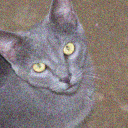

In [191]:
sample_image

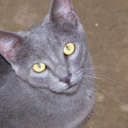

In [192]:
nearest_data